# Using selenium to book airticket

This is just a tutorial to showcase on using selenium. Not for actual usecase

# Requirements

- [Chrome Driver](https://sites.google.com/a/chromium.org/chromedriver/downloads)
- point the driver_path to the folder containing your chromedriver

In [4]:
from IPython.display import Image
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from urllib.parse import urlencode
from datetime import datetime,timedelta
import random
import json
import time

### Go to Airasia website
- Set user-agent
- Use chromedriver to open the page
-  A new browser window will spawn out

In [3]:
opts = Options()
opts.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.84 Safari/537.36")

# PATH-TO-CHROMEDRIVER
driver = webdriver.Chrome('chromedriver.exe',chrome_options=opts)
driver.get('https://www.airasia.com')

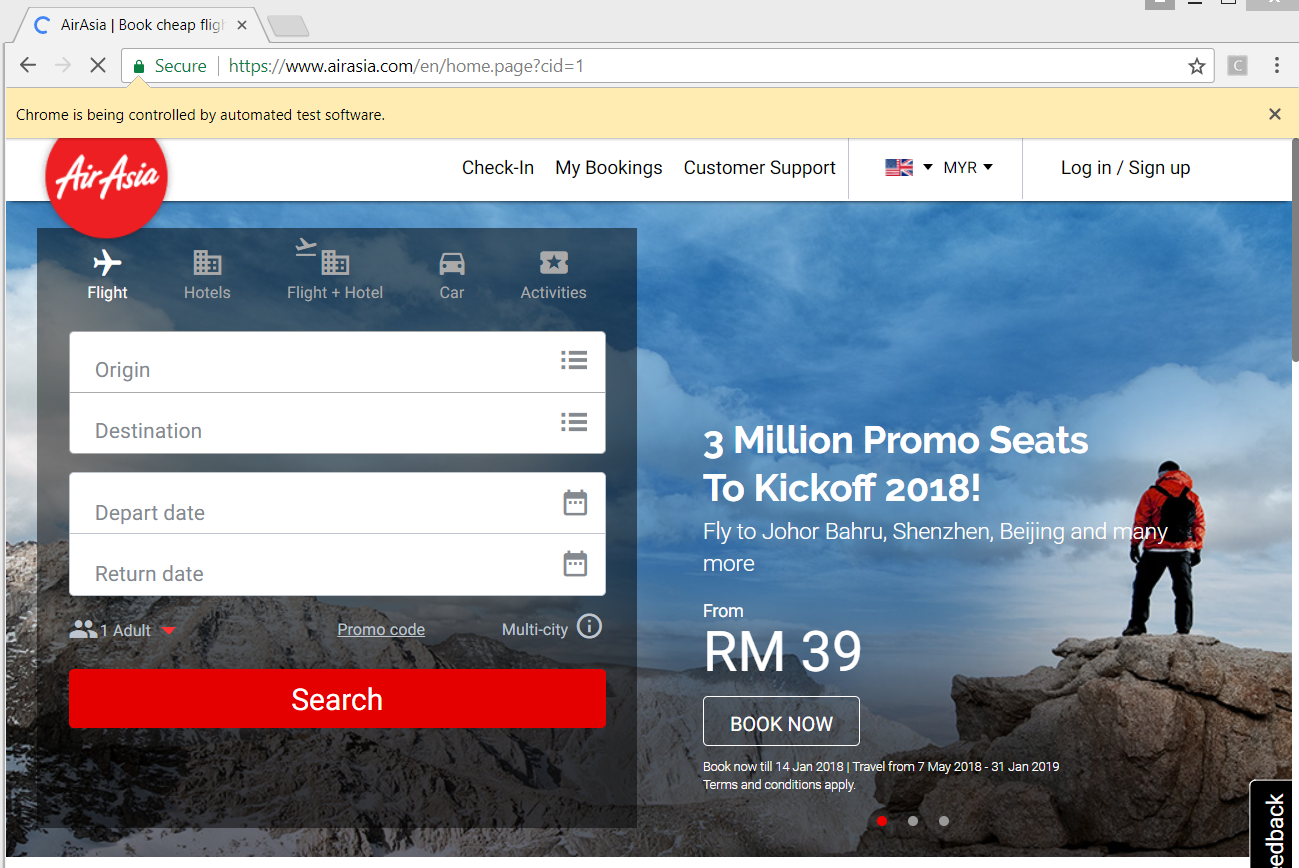

In [6]:
Image("1. airasia.png")

### Getting the choices of the flight origin and destination

In [7]:
origin = driver.find_element_by_xpath('//*[@id="select2-cb_origins-icon"]')
origin.click()
origin_list = driver.find_elements_by_xpath('//*[@id="cb_origins"]/option')

origin_list_details = []
for country in origin_list:
    if country.text != '':
        origin_list_details.append(json.loads(country.text))
        
origin_list_dict = {i:v for i,v in enumerate(origin_list_details) }

In [8]:
origin_list_dict[0]

{'Code': 'AOR',
 'Country': 'MALAYSIA',
 'EnCountry': None,
 'EnName': None,
 'Name': 'ALOR SETAR',
 'Pinyin': None}

In [9]:
origin_list_dict[1]

{'Code': 'AKL',
 'Country': 'NEW ZEALAND',
 'EnCountry': None,
 'EnName': None,
 'Name': 'AUCKLAND',
 'Pinyin': None}

### Getting site cookie

In [10]:
cookies_list = driver.get_cookies()
cookies_dict = {}
for cookie in cookies_list:
    cookies_dict[cookie['name']] = cookie['value']

cookies_dict

{'LanguageSelect': 'en',
 'X-CDN-Geo-City': 'SHAHALAM',
 'X-CDN-Geo-Country': 'MY',
 '__airasiaga': 'GA1.2.541156904.1515679516',
 '__airasiaga_gid': 'GA1.2.609000352.1515679516',
 '__gads': 'ID=50e48ec0c8f54462:T=1515679502:S=ALNI_MYMax-VqoZHE-VgkmBfu6J7wykhGA',
 '_gali': 'select2-cb_origins-icon',
 '_hp2_id.3785637731': '%7B%22userId%22%3A%222209039587287913%22%2C%22pageviewId%22%3A%223414799788523513%22%2C%22sessionId%22%3A%224170432704665846%22%2C%22identity%22%3Anull%2C%22trackerVersion%22%3A%223.0%22%7D',
 '_hp2_ses_props.3785637731': '%7B%22ts%22%3A1515679516536%2C%22d%22%3A%22www.airasia.com%22%2C%22h%22%3A%22%2Fen%2Fhome.page%22%7D',
 'currencySelect': 'RM',
 'optimizelyEndUserId': 'oeu1515679510164r0.29156299286648446',
 'true_loc': 'my'}

# Check the querystring

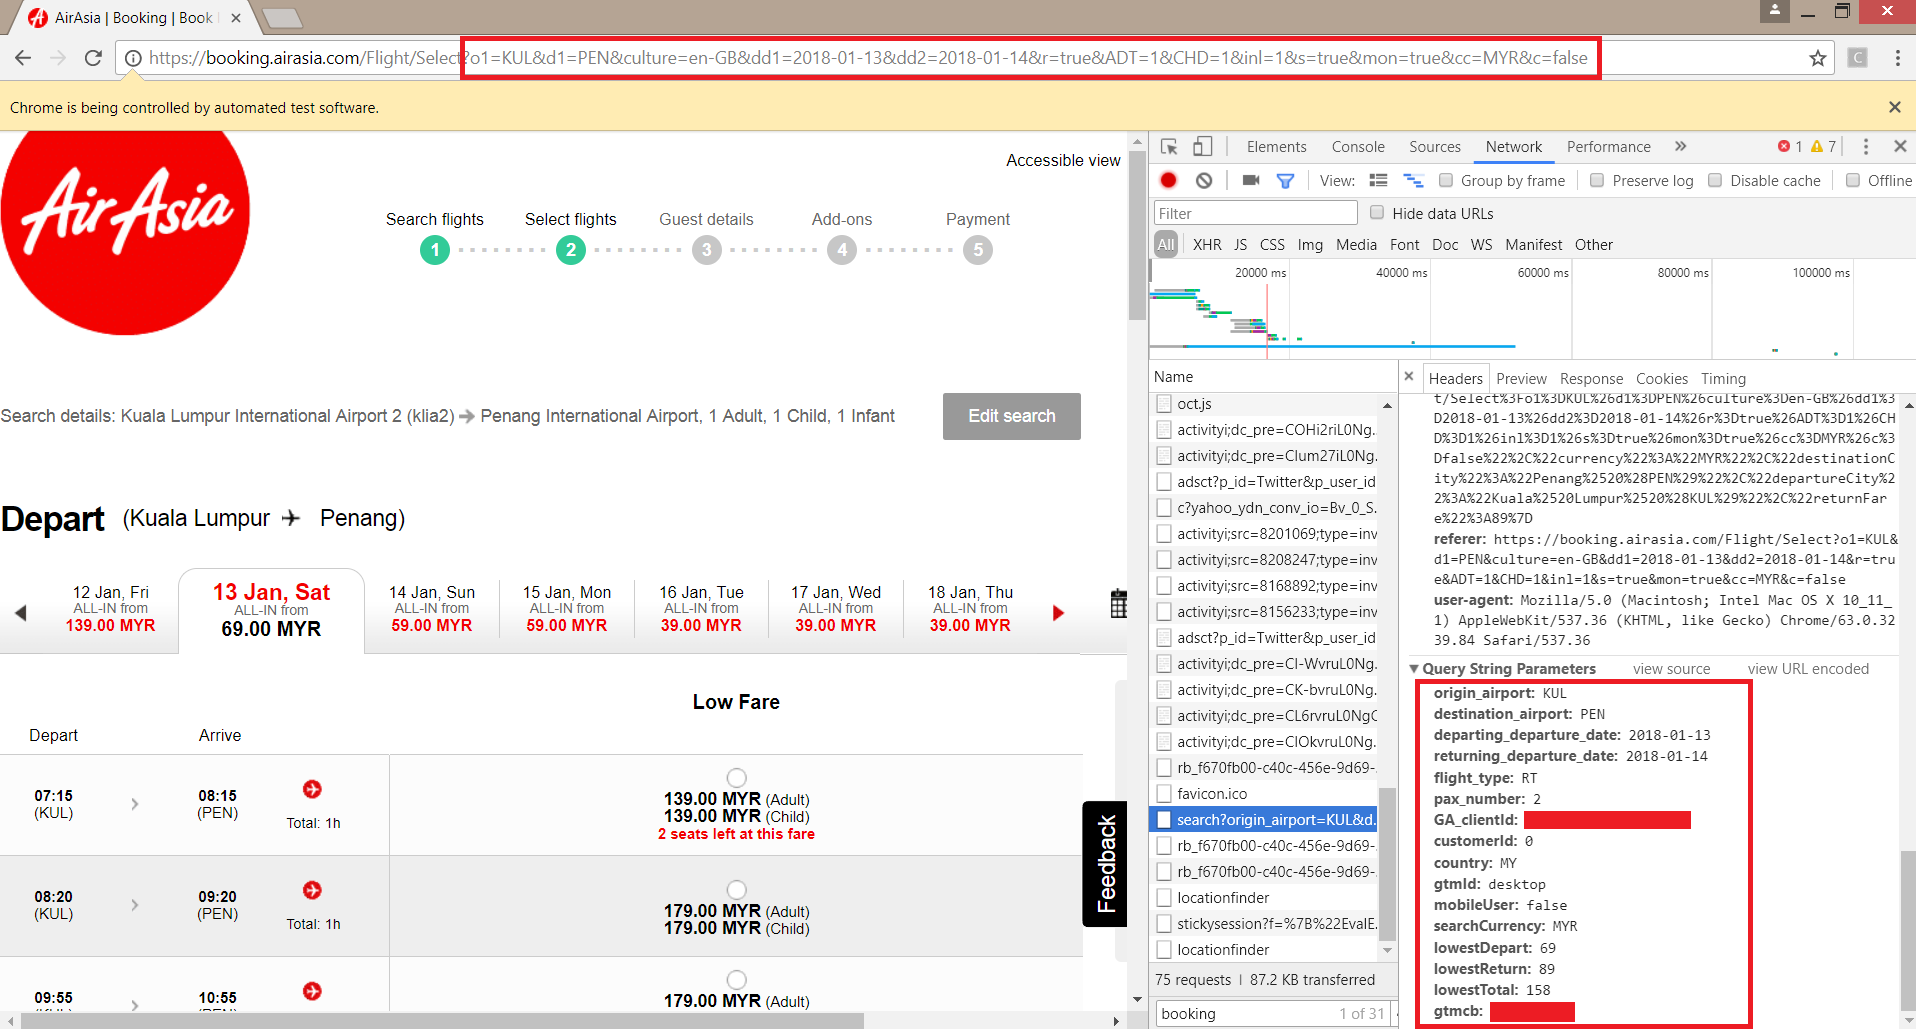

In [13]:
Image("2.querystring.png")

# Generate random parameters to fit in

In [16]:
def gen_random_data():
    
    def params(ori,dest,date1,date2=None,adult=1,child=None,infant=None,**kwargs):
        param_dict = [('o1',ori),
                      ('d1',dest),
                      ('culture','en-GB'),  
                      ('dd1',date1),
                      ('dd2',date2),
                      ('r','true'),
                      ('ADT',adult),
                      ('CHD',child),
                      ('inl',infant),
                      ('s','true'),
                      ('mon','true'),
                      ('cc','MYR'),
                      ('c','false')]
        return [(k,v) for k,v in param_dict if v is not None]

    def returndate(depart_date):
        day = depart_date+timedelta(days=random.randint(3,10))
        return day.date().isoformat()

    day = datetime(2018,2,random.randint(2,28))  # Random generate dates in 2018 February
    random_gen = {
        'ori':random.randint(0,157),
        'dest':random.randint(0,157),
        'date1':day.date().isoformat(),
        'date2':random.choice([None,returndate(day)]),
        'adult':random.randint(1,2),
        'child':random.randint(0,1),
        'luggage':random.randint(1,3),
    }
    if random_gen['ori']!=random_gen['dest']:
        random_gen['ori'] = origin_list_dict[random_gen['ori']]['Code']
        random_gen['dest'] = origin_list_dict[random_gen['dest']]['Code']
        return random_gen 
    else:
        gen_random_data()

- ori  : origin
- dest : destination
- date1: depart date
- date2: return date (if None, means it is a one way trip)
- adult: no. of adult (at least 1)
- child: no. of child
- luggage: luggage option

In [30]:
random_data = gen_random_data()
random_data

{'adult': 2,
 'child': 0,
 'date1': '2018-02-08',
 'date2': None,
 'dest': 'MAA',
 'luggage': 2,
 'ori': 'REP'}

In [31]:
querystring = params(**random_data)
url = 'https://booking.airasia.com/Flight/Select?'+urlencode(querystring)
url

'https://booking.airasia.com/Flight/Select?o1=REP&d1=MAA&culture=en-GB&dd1=2018-02-08&r=true&ADT=2&CHD=0&s=true&mon=true&cc=MYR&c=false'

###### Possibility
### If route not valid..... Getting valid route with the random generate origin and destination
- The page will redirect to booking.airasia.com if the ori -> dest route is not valid

In [32]:
def rerun_again():
    random_data = gen_random_data()
    querystring = params(**random_data)
    url = 'https://booking.airasia.com/Flight/Select?'+urlencode(querystring)
    driver.get(url)
    return random_data

def get_valid_route():
    while driver.current_url == 'https://booking.airasia.com/':
        random_data = rerun_again()
        print('Not valid, gen again...')
        time.sleep(5)
    print(random_data['ori'],random_data['dest'])
    return random_data

driver.get('https://booking.airasia.com/')
    
random_data = get_valid_route(random_data)

random_data

Not valid, gen again...
BOM DMK


{'adult': 1,
 'child': 1,
 'date1': '2018-02-08',
 'date2': '2018-02-17',
 'dest': 'DMK',
 'luggage': 1,
 'ori': 'BOM'}

### Check availability: if not available, search again

In [44]:
def check_availability(return_date,return_availability='-'):
    depart_availability = driver.find_element_by_xpath('//*[@id="availabilityForm"]/div[1]//li[@class="active "]//h4')
    if return_date != None:
        return_availability = driver.find_element_by_xpath('//*[@id="availabilityForm"]/div[2]//li[@class="active "]//h4')
        return_availability = return_availability.text
    return (depart_availability.text, return_availability)

def rerun_if_unavailable(random_data):
    availability = check_availability(random_data['date2'])
    if 'Unavailable' in availability:
        driver.get('https://booking.airasia.com/')
        random_data = get_valid_route()
        time.sleep(5)
        rerun_if_unavailable()
    else:
        return random_data    
    
random_data = rerun_if_unavailable(random_data)

random_data

{'adult': 2,
 'child': 0,
 'date1': '2018-02-17',
 'date2': '2018-02-23',
 'dest': 'SIN',
 'luggage': 3,
 'ori': 'BDO'}

### Route contains unavailable search result

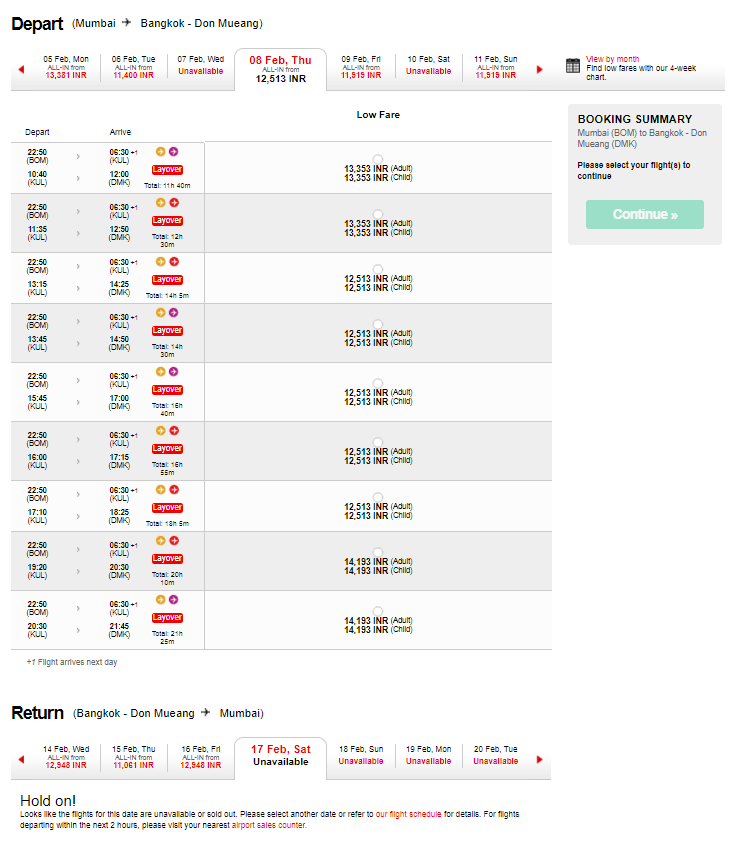

In [34]:
Image('3. availability.png')

### Route with both available result

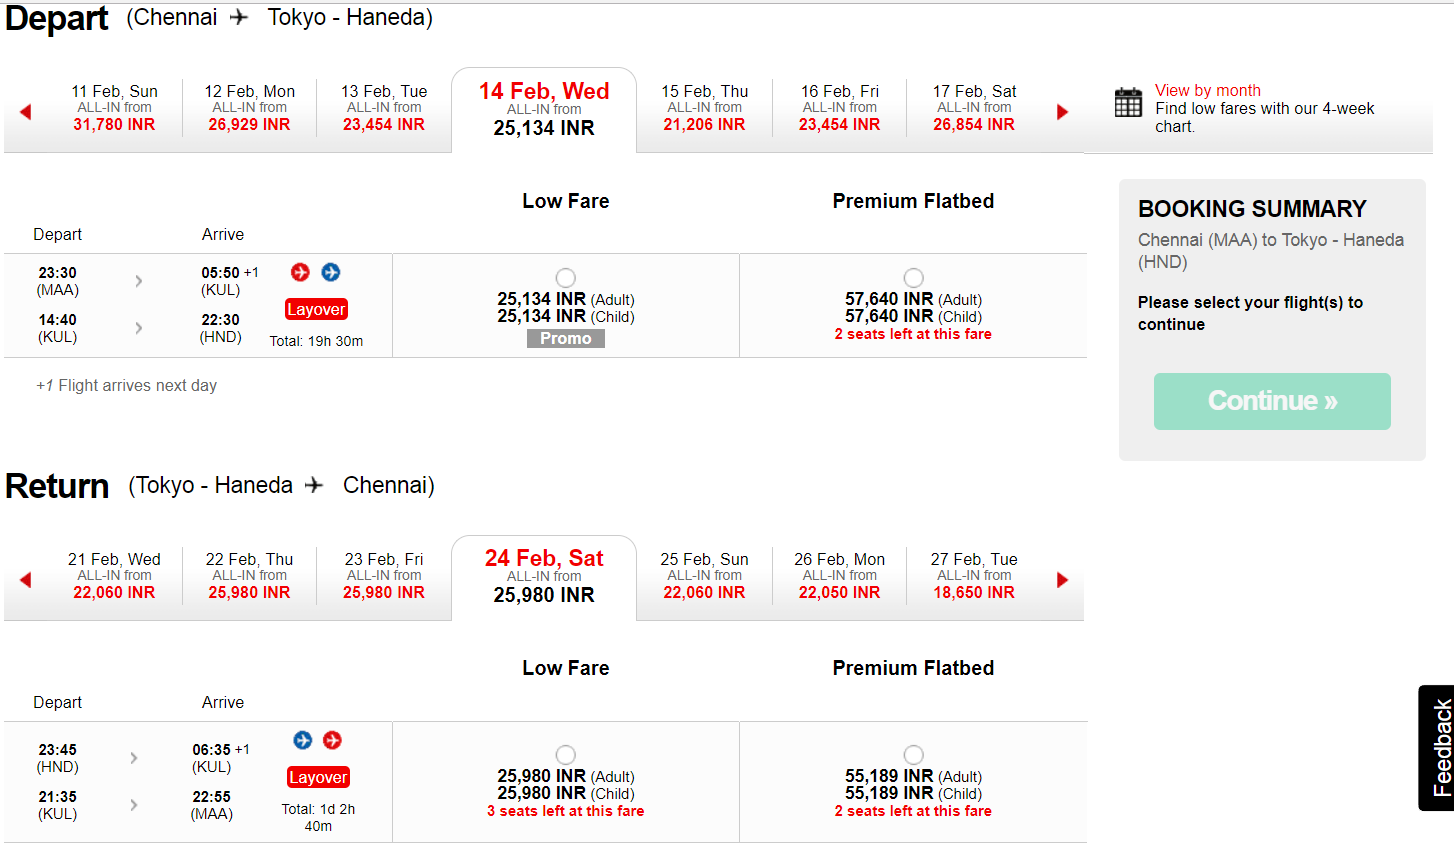

In [45]:
Image('3. availability_2.png')

### Select first choice from the searched depart and/or return time, and obtain the info

In [46]:
def one_way(availability):
    depart_fare = availability[0]
    result_block = driver.find_elements_by_xpath('//table[@class="table avail-table"]')
        
    light_dark = result_block[0].find_elements_by_xpath('.//tbody[1]/tr[@class="fare-light-row"]') + \
                 result_block[0].find_elements_by_xpath('.//tbody[1]/tr[@class="fare-dark-row"]')
    depart_searches = [i.text.replace('\n',' ') for i in light_dark if 'Total' in i.text]
    driver.find_element_by_xpath('//*[@id="availabilityForm"]/div[1]/table/tbody/tr[3]/td[2]/div/div/div[1]/div').click()
    return result_block, depart_searches, '-'

def two_way(availability):
    time.sleep(2)
    return_fare = availability[1]
    result_block,depart_searches,_ = one_way(availability)
    light_dark = result_block[1].find_elements_by_xpath('.//tbody[1]/tr[@class="fare-light-row"]') + \
                 result_block[1].find_elements_by_xpath('.//tbody[1]/tr[@class="fare-dark-row"]')
    return_searches = [i.text.replace('\n',' ') for i in light_dark if 'Total' in i.text]
    driver.find_element_by_xpath('//*[@id="availabilityForm"]/div[2]/table/tbody/tr[3]/td[2]/div/div/div[1]/div').click()
    return result_block, depart_searches, return_searches

In [47]:
if random_data['date2'] != None:
    _, depart_searches, return_searches = two_way(availability)
else:
    _, depart_searches, return_searches = one_way(availability)

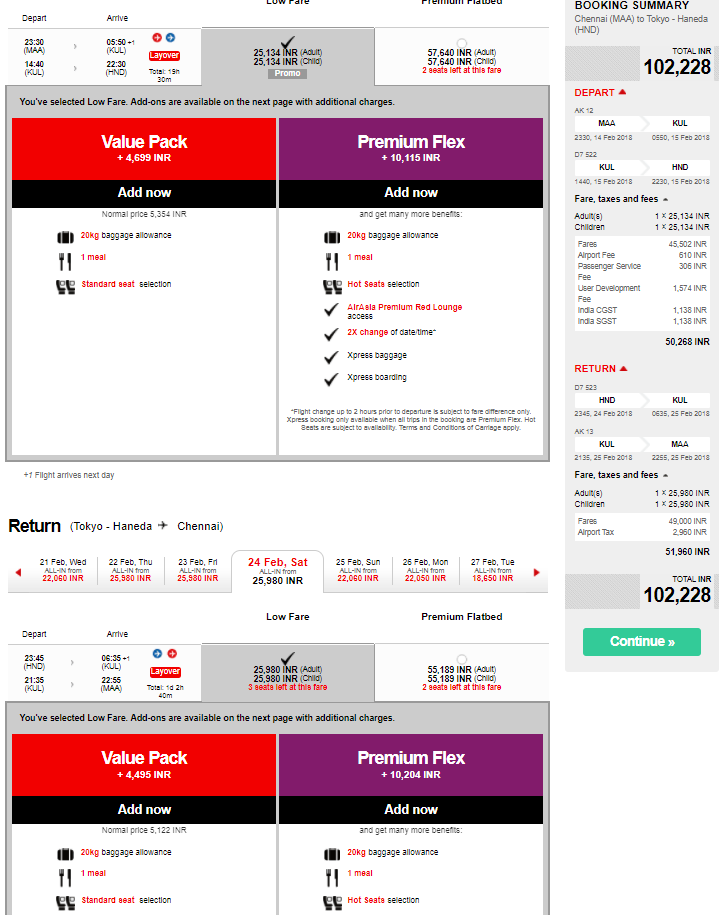

In [49]:
Image('4. select_trip.png')

In [50]:
depart_searches

['23:30 (MAA) 05:50 (KUL) +1 14:40 (KUL) 22:30 (HND) Layover Total: 19h 30m 25,134 INR (Adult) 25,134 INR (Child) Promo 57,640 INR (Adult) 57,640 INR (Child) 2 seats left at this fare']

In [51]:
return_searches

['23:45 (HND) 06:35 (KUL) +1 21:35 (KUL) 22:55 (MAA) Layover Total: 1d 2h 40m 25,980 INR (Adult) 25,980 INR (Child) 3 seats left at this fare 55,189 INR (Adult) 55,189 INR (Child) 2 seats left at this fare']

### Click Submit

In [54]:
driver.find_element_by_xpath('//*[@id="submit_search_button"]').click()

## Continue as guest
driver.find_element_by_xpath('//*[@id="airAsiaMember_close"]').click()

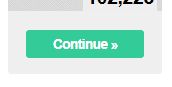

In [53]:
Image('5. continue.png')

### Fill in passenger info

In [55]:
def fill_passenger_info(no,g_name,surname,gender,dob,mob,yob):
    # Send text to the input bar
    given_name = driver.find_element_by_xpath('//*[@id="airAsiaPassengers_{}__Name_First"]'.format(no))
    given_name.send_keys(g_name)
    time.sleep(1)
    family_name = driver.find_element_by_xpath('//*[@id="airAsiaPassengers_{}__Name_Last"]'.format(no))
    family_name.send_keys(surname)
    time.sleep(1)
    
    # Select the radio buttom
    gender = driver.find_elements_by_xpath('//*[@id="airAsiaPassengers_{}__Name_Title"]'.format(no))[gender].click()
    
    # Select from dropdown
    nationality = driver.find_element_by_xpath('//*[@id="airAsiaPassengers_{}__Info_Nationality"]/option[@value="MY"]'.format(no)).click()
    date_of_birth = driver.find_element_by_xpath('//*[@id="date_of_birth_day_{}"]/option[@value="{}"]'.format(no,dob)).click()
    month_of_birth = driver.find_element_by_xpath('//*[@id="date_of_birth_month_{}"]/option[@value="{}"]'.format(no,mob)).click()
    year_of_birth =  driver.find_element_by_xpath('//*[@id="date_of_birth_year_{}"]/option[@value="{}"]'.format(no,yob)).click()

In [57]:
adult = {'g_name' : 'Neurotic',
        'surname' : 'Lee',
        'gender':1,
        'dob' : 28,
        'mob' : 10,
        'yob' : 1993}
kid = {'g_name':'Peter',
        'surname':'Pan',
        'gender':0,
        'dob':1,
        'mob':2,
        'yob':2015}

fill_passenger_info(0,**adult)
fill_passenger_info(1,**kid)

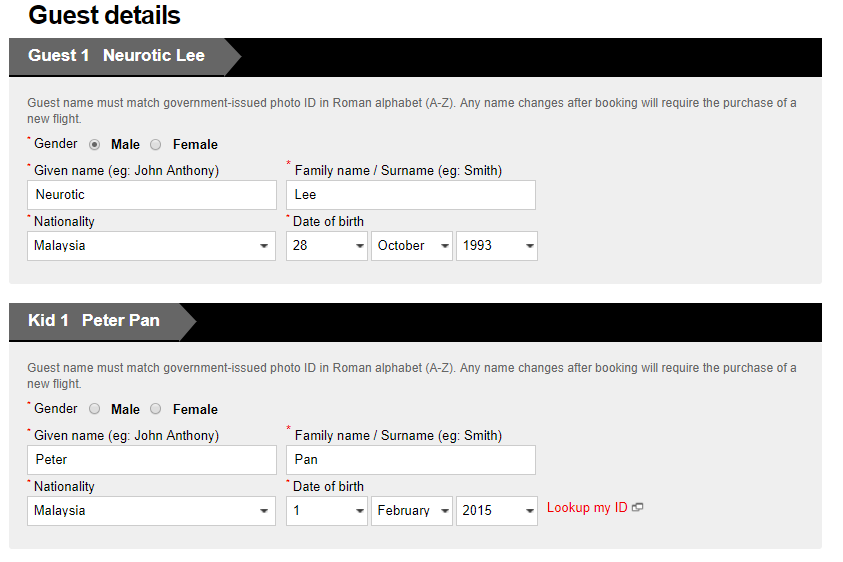

In [58]:
Image('6. passenger.png')

### Submit

In [61]:
driver.find_element_by_xpath('//*[@id="submit_search_button"]').click()

In [78]:
def select_baggage(ppl,luggage):
    driver.find_element_by_xpath('//*[@id="baggage_journey_0_passenger_{}"]/option[{}]'.format(ppl,luggage)).click()

In [80]:
luggage = random_data['luggage']
select_baggage(0,luggage) # Adult
select_baggage(1,luggage) # Kid

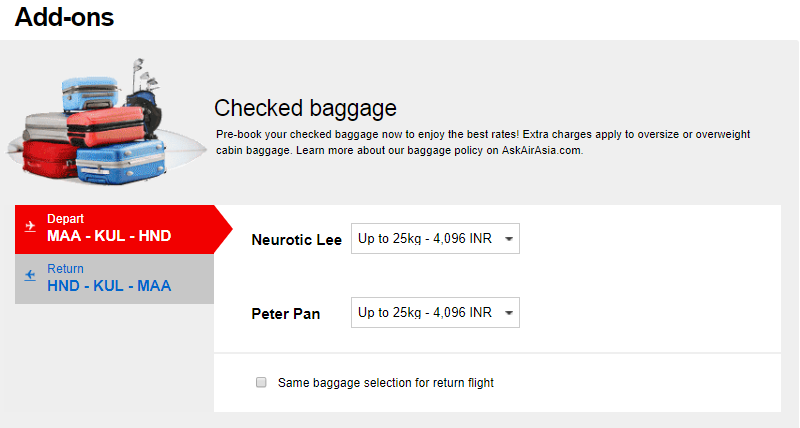

In [91]:
Image('7. luggage.png')

In [83]:
driver.find_element_by_xpath('//*[@id="insuranceForm"]/div[2]/span/div').click()
driver.find_element_by_xpath('//*[@id="submit_search_button"]').click()

### Proceed to payment..........